In [1]:
path_folder = "/Users/inkyunpark/Documents/ghent_graduate/MA1/Design_Project/Data.nosync/Liver/hpc_output_liver_small"
path_masks = "/Users/inkyunpark/Documents/ghent_graduate/MA1/Design_Project/Data.nosync/hpc_output_liver_full/2022-11-19_20-13-43/masks.npy"

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import squidpy as sq
from skimage import io
import scanpy as sc
import matplotlib.pyplot as plt
from anndata import AnnData
import yaml
from yaml.loader import SafeLoader
from typing import List
import time
import os
from dotenv import load_dotenv

In [2]:
maskPath = "/Users/inkyunpark/Documents/ghent_graduate/MA1/Design_Project/Data.nosync/Liver/hpc_output_liver_full/2022-11-19_20-13-43/masks.npy"
mask = np.load(maskPath)

ValueError: cannot reshape array of size 6307473 into shape (12864,10720)

In [3]:
from napari_sparrow import functions as fc

In [58]:
# packages in function.py

import warnings
from itertools import chain
from typing import List, Optional, Tuple

import cv2
import geopandas
import matplotlib
import matplotlib.colors as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scanpy as sc
import seaborn as sns
import shapely
import squidpy as sq
import torch
from anndata import AnnData
from basicpy import BaSiC
from cellpose import models
from rasterio import features
from scipy import ndimage

In [4]:
def read_in(path_folder: str) -> AnnData:
    # Find all sample folders
    folders = [ name for name in os.listdir(path_folder) if os.path.isdir(os.path.join(path_folder, name)) ]
    print(folders)

    adata_folder = None

    for folder in folders:
        if folder == ".submitit":
            continue
            
        run_folder = path_folder + "/" + folder + "/"

        # If adata file exists, concat to adata folder
        if os.path.exists(run_folder + "adata.h5ad"):
            adata = sc.read(run_folder + "adata.h5ad")

            # Fetch tissue from config if exists
            if os.path.exists(run_folder + ".hydra/config.yaml"):
                with open(run_folder + ".hydra/config.yaml") as infile:
                    data = yaml.load(infile, Loader=SafeLoader)
                    sample = data["dataset"]["image"].split("_")[2]
                    adata.obs["tissue"] = sample
                    adata.obs["group"] = sample.split("-")[0]
            else:
                adata.obs["tissue"] = folder
                print("config file does not exist: \n" + run_folder)

            # Concatenate adata if adata_folder exists
            if adata_folder:
                adata_folder = adata_folder.concatenate(adata)
            else:
                adata_folder = adata

        else:
            print("Adata file does not exist:\n" + run_folder + "adata.h5ad")
    return adata_folder, folders

In [5]:
import warnings
# Supress anndata dtype warnings
warnings.filterwarnings('ignore', '.*anndata.*')

adata, folders = read_in(path_folder)

['0', '.submitit']


/opt/homebrew/Caskroom/miniconda/base/envs/napari-sparrow/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## What is Anndata?
[Tutorial](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html)

Anndata summarizes n observations where each observations is represented as d-dimensional (variable of feature) vectors into annotated data matrices.
For example, in scRNA-seq data, row corresponds to cells and col corresponds to gene_id. Each item in this matrix might have additional metadata (metadata is a data to explain and index other data), such as donor information for each cell or alternative gene symbols for each gene. Plus, unstructured metadata might exist too.

<code>adata.obs</code>: one-dimensional annotation of observations <br>
<code>adata.var</code>: one-dimensional annotation of variables/features <br>
<code>adata.obsm</code>: multidimensional annotation of observations <br>
<code>adata.uns</code>: unstructured annotation, data is stored in dictionary. <br>

We can use backed mode to partially read large .h5ad file.


In [6]:
# Describe adata
test_adata = adata.var
print(type(test_adata))
print(adata.obsm)
adata.obsm["polygons"]

<class 'pandas.core.frame.DataFrame'>
AxisArrays with keys: X_pca, X_umap, polygons, segmentation_features, spatial


,linewidth,X,Y
1,1,2125.807170,961.275849
2,1,2069.672756,1037.150516
3,1,2016.350549,1053.463956
4,1,2033.389359,1103.582583
5,1,1748.441143,1123.930286
...,...,...,...
199,1,2043.432701,2121.952133
200,1,1660.142822,2124.612200
201,1,358.801415,2128.318825
202,1,1290.094719,2135.405855


# Preprocess adata
This part is consisting of 
- QC: All cells with less then 10 genes and all genes with less then 5 cells are removed.
- Nuclear size normalization: If True, normalization based on the size of cell/nucleus. If False, normal library size normalization.
- Filtering: Cells are filtered by size of nucleus. We can set min_size and max_size. Also, the function calculates total cell size and deletes the cell when estimated size (distance) is really large, assuming that more than one cells are 

In visualization, PCA and UMAP are utilized to summarize high dimensional data into into human readable 2 dimensional plots. 
- PCA (principal component analysis): Data is summarized on two components: PC1 and PC2. PC1 captures the most variation and PC2 captures the second most variation (PC2 is perpendicular to PC1). Genes with great variation has the greatest influence on the PC plots. If datas are well separated, we can also spot clusters in PCA plots. PCA only works well when the first 2 PC account for most of the variation in the data. In very complicated datasets, PCA might not be good method.
- UMAP (uniform manifold approximation and projection): Datas are summarized into low dimentional graph by preserving clusters information at high dimension using similarity scores (nearest neighbours and minimum distances, these data describes location information of each data point in high dimensional plot). 

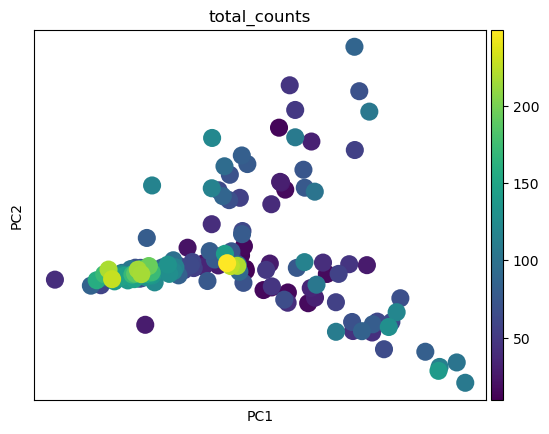

In [7]:
sc.tl.pca(adata, svd_solver='arpack',n_comps=50)
sc.pl.pca(adata, color='total_counts') 

In [ ]:
# BUGS
# ValueError: The truth value of a Series is ambiguous, occurs at adata.obsm["polygons"].plot

fc.plot_shapes(adata, column="total_counts")

In [ ]:
# BUGS
# In filter_on_size, adata.obsm["polygons"].centroid does not exist. (where we add new centroid features to the adata?)

adata, filtered = fc.filter_on_size(adata, min_size=500)
print(str(filtered) + " cells were filtered out based on size.")
#fc.plot_shapes(adata, column="distance")

In [ ]:
# BUGS

adata = fc.clustering(adata, 17, 35)
fc.clustering_plot(adata)
fc.plot_shapes(adata, column="leiden")

In [ ]:
#BUGS

crd = [2000, 4000, 3000, 5000]
fc.plot_shapes(adata, column="leiden", crd=crd, alpha=0.8)

# Annotation

Here, cells are annotated using the marker gene list. 

- ScoreGenes: Create dictionary of marker genes of samples and scores per cluster
    - sc.tl.score_genes updates adata with additioanl field score_name
- correct marker genes

In [59]:
# BUGS
# TypeError: cannot unpack non-iterable int object, occurs at for row, value in (df_markers[i]):
# Type of df_markers is <class 'pandas.core.frame.DataFrame'>

path_mg = "/Users/inkyunpark/Documents/ghent_graduate/MA1/Design_Project/Data.nosync/Liver/markerGeneListMartinNoLow.csv"
mg_dict, scoresper_cluster = fc.scoreGenes(adata, path_mg, repl_columns={"Tot_Score_": "", "uppfer": "upffer"}, del_genes=["Hepatocytes", "LSEC45"])
fc.scoreGenesPlot(adata, scoresper_cluster, 5)

TypeError: cannot unpack non-iterable int object

In [66]:
path_marker_genes = "/Users/inkyunpark/Documents/ghent_graduate/MA1/Design_Project/Data.nosync/Liver/markerGeneListMartinNoLow.csv"
df_markers = pd.read_csv(path_marker_genes, index_col=0)
repl_columns = {"Tot_Score_": "", "uppfer": "upffer"}

if repl_columns:
    for column, replace in repl_columns.items():
        df_markers.columns = df_markers.columns.str.replace(column, replace)

print(type(df_markers["portal_vein_EC45"].row))

genes_dict = {}
for i in df_markers:
    genes = []
    for row, value in (df_markers[i]):
        if value > 0:
            genes.append(df_markers.index[row])
    genes_dict[i] = genes
    print(genes)
    genes_dict
    break
print(genes_dict)

AttributeError: 'Series' object has no attribute 'row'

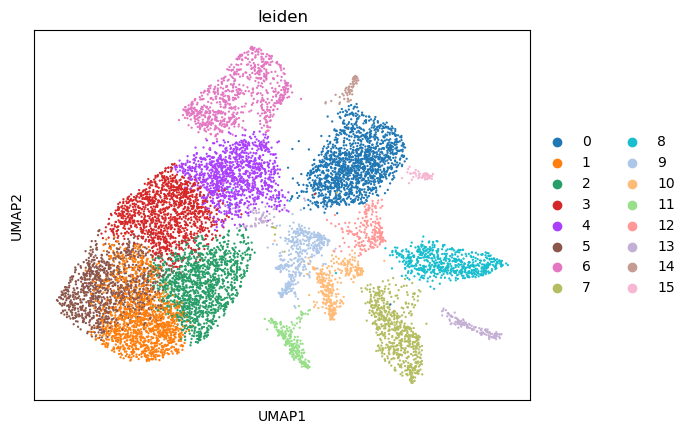

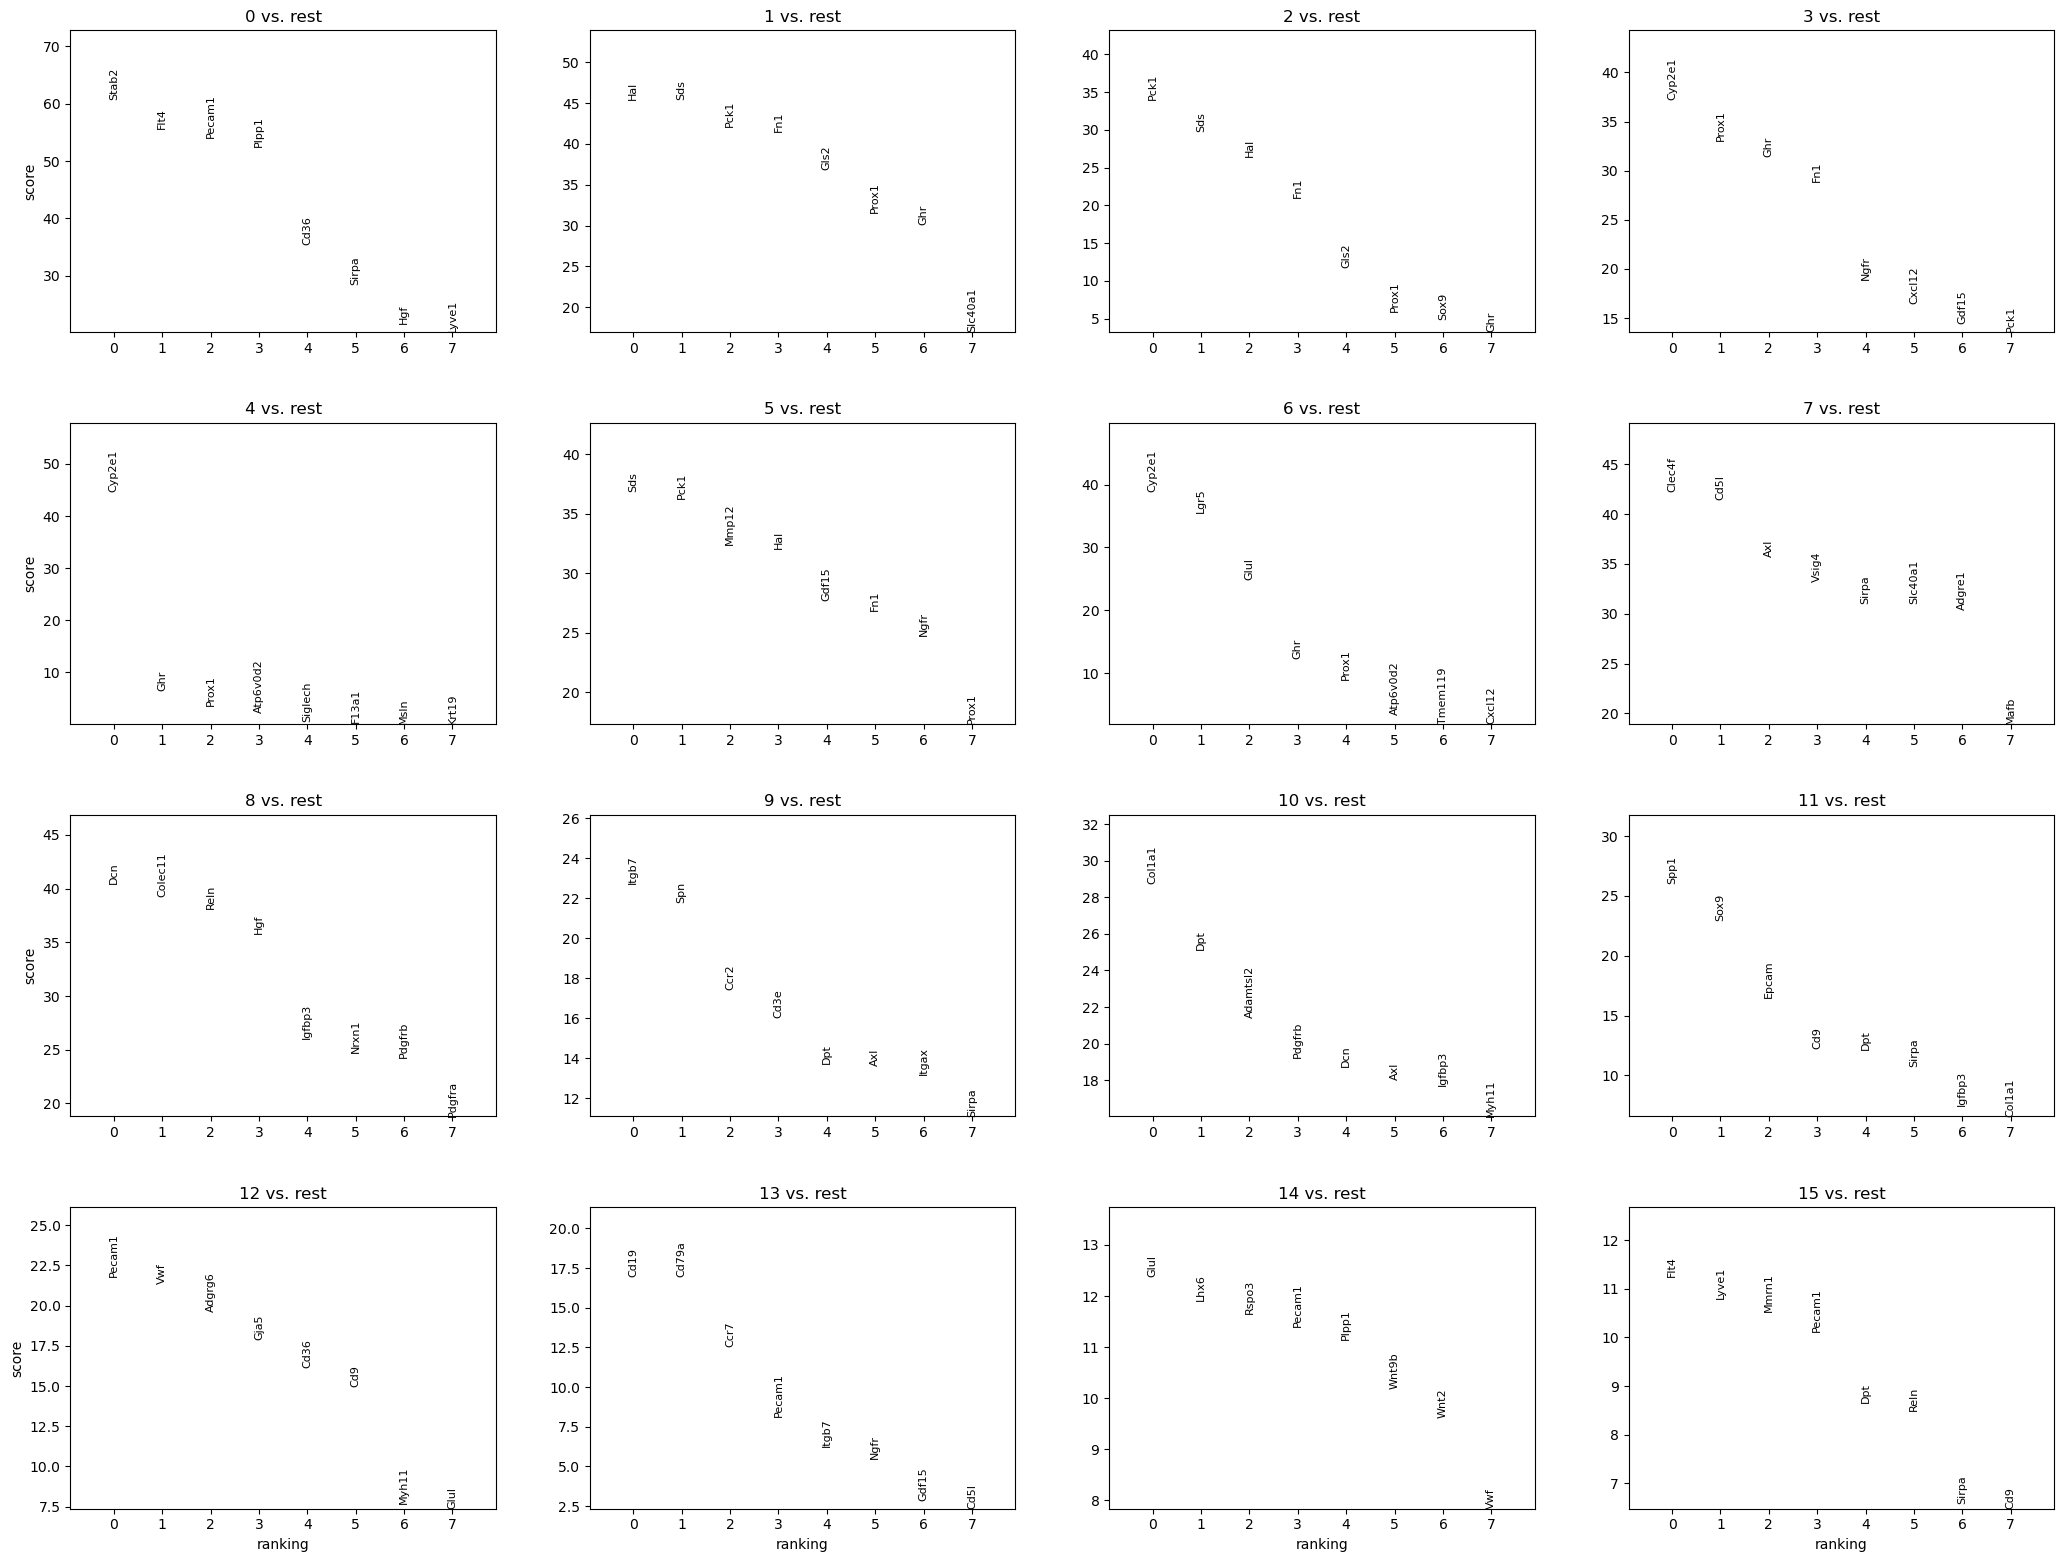

In [95]:
adata = fc.clustering(adata, 16, 30)
fc.clustering_plot(adata)

(-6.534909391403199,
 16.433275365829466,
 -4.987341129779816,
 16.740557634830473)

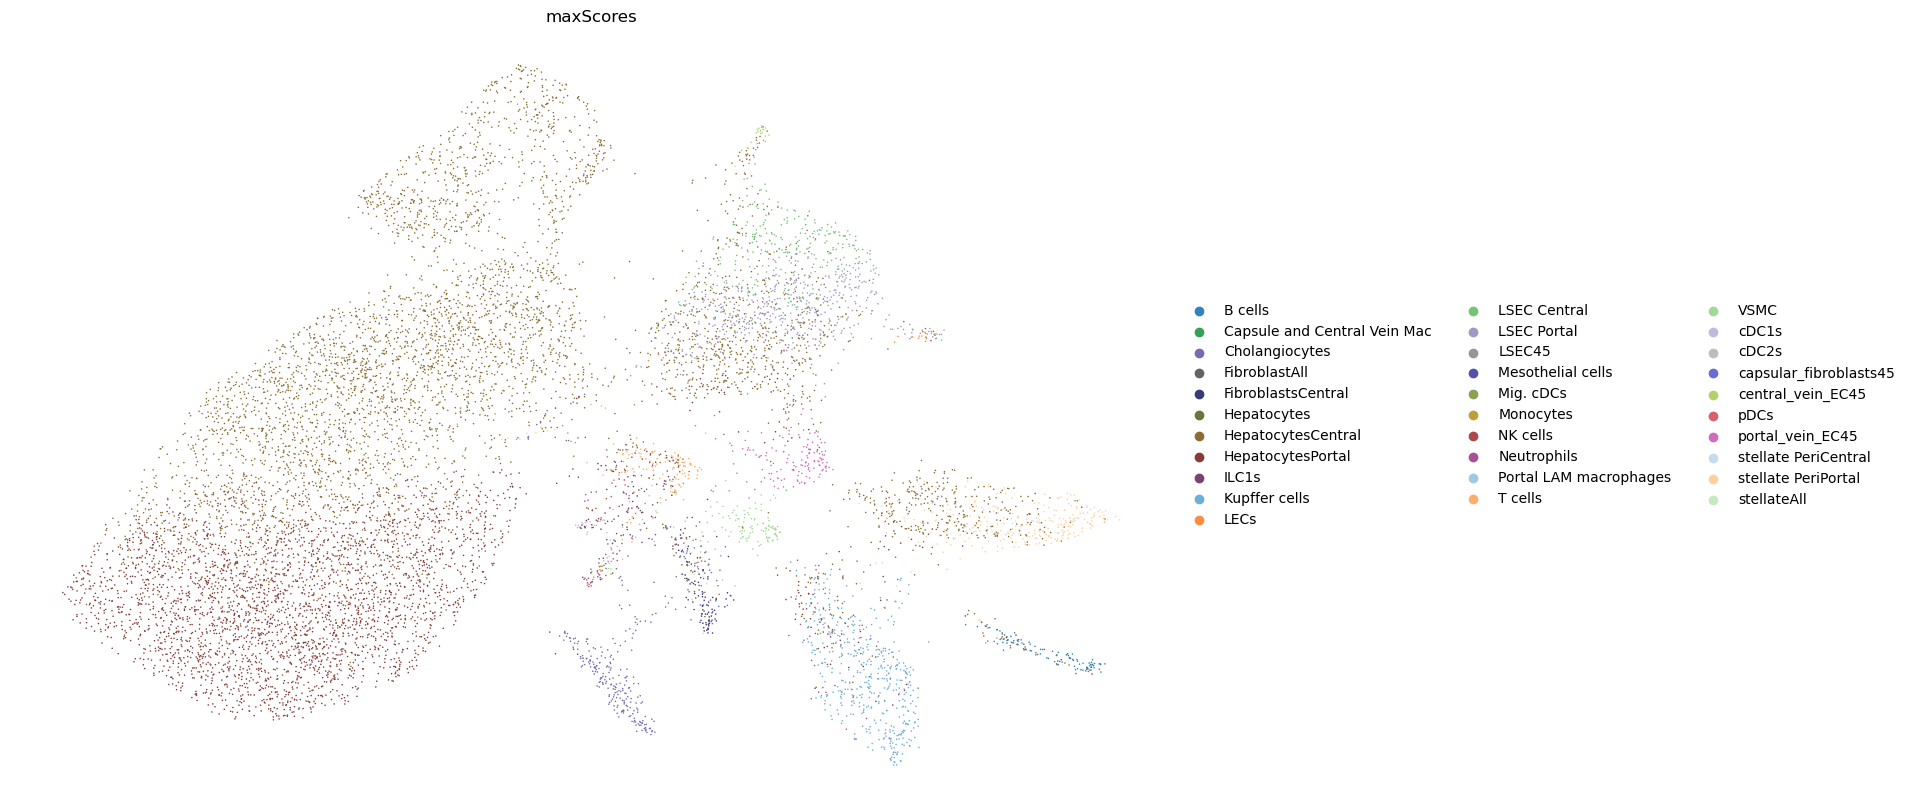

In [96]:
fig,ax =plt.subplots(1,1,figsize=(15,10))
sc.pl.umap(adata,color=['maxScores'],ax=ax,size=5,show=False)
ax.axis('off')

In [97]:
adata, filtered = fc.filter_on_size(adata, min_size=500)
print(str(filtered) + " cells were filtered out based on size.")
fc.plot_shapes(adata, column="distance")

AttributeError: 'DataFrame' object has no attribute 'centroid'